# Test with Stanza parsing

In [ ]:
import stanza
# stanza.download('en') # download English model
nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse') # initialize English neural pipeline

In [ ]:
sents = [
        "hell yeah!"
        #  'The boss runs the company.',
        #  'The company is run by the boss', 
        #  'The company is run in the dark.', 
        #  'He runs in the jungle.',
        #  'The roads run through the city.',
        #  'He runs his finger through his hair.',
        #  'The computer runs fast.',
        #  'The car runs really fast.'
         ]

# sents = ['MISS NORMAN : Will you do me the honour to meet me at the bridgehead at half-past nine practically at once ?']
target = 'miss'

In [ ]:
for sent in sents:
    doc = nlp(sent) # run annotation over a sentence
    print('sentence:', sent)
    # print(doc)
    # print(doc.entities)
    print(*[f'word: {word.text}\tlemma: {word.lemma}\tpos: {word.pos}\tid: {word.id}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')
    print('end')

In [ ]:
import stanza
from collections import defaultdict

sents = ['The boss runs the company.',
         'The company is run by the boss', 
         'The company is run in the dark.', 
         'He runs in the jungle.',
         'The roads run through the city.',
         'He runs his finger through his hair.',
         'The computer runs fast.',
         'The car runs really fast.']
target = 'run'

# 1. load the English pipeline (tokeniser-POS-lemma-dependency)
nlp = stanza.Pipeline(
        'en', processors='tokenize,pos,lemma,depparse',
        tokenize_no_ssplit=True,  # treat each string as a single sentence
        verbose=False)

results = []               # (sent_id, dep_lemma, deprel)
for sent_id, text in enumerate(sents, 1):
    doc = nlp(text)
    sent = doc.sentences[0]               # exactly one per string
    for w in sent.words:                  # iterate over tokens/words
        if w.lemma == target:             # <- our target lemma
            head_id = w.id
            # collect *immediate* dependents of this “run”
            for d in sent.words:
                if d.head == head_id:
                    results.append((sent_id, d.lemma, d.deprel))

# pretty-print
for sent_id, lem, rel in results:
    print(f'S{sent_id}: {lem:<10}  {rel}')


In [ ]:
# sents = ['The boss runs the company.',
#          'The company is run by the boss', 
#          'The company is run in the dark.', 
#          'He runs in the jungle.',
#          'The roads run through the city.',
#          'He runs his finger through his hair.',
#          'The computer runs fast.',
#          'The car runs really fast.'
#          ]

# sents = [
#     "Freedom is priceless.",
#     "She fought for freedom during the revolution.",
#     "The court finally granted him the freedom to speak openly.",
#     "Within the classroom, freedom of thought nurtures creativity.",
#     "The towering bronze sculpture, Freedom, dominates the plaza.",
#     "After the last exam, the students burst outside in pure freedom.",
#     "Digital tracking can quietly erode freedom online.",
#     "We debated whether freedom or security mattered more.",
#     "Without self-control, freedom often collapses into chaos.",
#     "He inhaled deeply, freedom flooding his lungs at the prison gates."
# ]

# sents = [
#     "The table shook during the earthquake.",
#     "She carved her initials into the wooden table.",
#     "After dinner, they sat around the table and talked for hours.",
#     "The architect presented a glass table as the room's centerpiece.",
#     "Please table the motion until next week’s meeting.",
#     "We sorted the data into a table for easier comparison.",
#     "The cat leapt onto the table, knocking over a vase.",
#     "Negotiators agreed to table further discussion until sunrise.",
#     "Beneath the table, a hidden drawer contained old photographs.",
#     "A picnic table stood alone under the oak tree."
# ]

sents = [
    "This article is interesting.",
    "An interesting twist changed the plot completely.",
    "He found the lecture interesting despite the late hour.",
    "Someone interesting moved into the apartment next door.",
    "The most interesting of the artifacts was the jade mask.",
    "Keep your questions interesting and concise.",
    "They made the workshop interesting by adding hands-on demos.",
    "What I find interesting is how quickly trends shift.",
    "Do you have anything interesting to read on the train?",
    "Interesting, she thought, how silence can speak louder than words."
]


TARGET = 'interesting' 

MAX_DEPTH  = 2             # you can pass (1,), (2,), (1,2,3) …


In [ ]:
import stanza
from collections import defaultdict, deque

nlp = stanza.Pipeline(
        "en",
        processors="tokenize,pos,lemma,depparse",
        tokenize_no_ssplit=True,
        verbose=False)

# ------------------------------------------------------------------ #
def collect_connected(sent, target_lemma, max_depth):
    """
    Return {depth: [(lemma, path)]} where 'path' is a string like
    '↓obj' or '↑nsubj:pass > ↓obl' showing the route from the target
    to the node.  Traversal is undirected, up to max_depth edges.
    """
    id2word   = {w.id: w for w in sent.words}
    neighbours = defaultdict(list)                  # id -> [(word, label)]

    # build bidirectional edges
    for w in sent.words:
        if w.head == 0:                             # ROOT has no parent
            continue
        head = id2word[w.head]
        neighbours[w.id].append((head, f"↑{w.deprel}"))   # child -> parent
        neighbours[head.id].append((w, f"↓{w.deprel}"))   # parent -> child

    result = defaultdict(list)                      # depth -> [(lemma, path)]
    for w in sent.words:
        if w.lemma != target_lemma:
            continue                                # other lemmas not our start
        q = deque([(w, 0, [])])                     # node, depth, path so far
        visited = {w.id}
        while q:
            node, d, path = q.popleft()
            if d == max_depth:                      # stop expanding beyond limit
                continue
            for nb, rel in neighbours[node.id]:
                if nb.id in visited:
                    continue
                nd     = d + 1
                npath  = path + [rel]
                result[nd].append((nb.lemma, " > ".join(npath)))
                visited.add(nb.id)
                q.append((nb, nd, npath))
    return result
# ------------------------------------------------------------------ #

all_hits = defaultdict(lambda: defaultdict(list))   # sent_id -> depth -> items
for sid, text in enumerate(sents, 1):
    sent = nlp(text).sentences[0]
    dep_map = collect_connected(sent, TARGET, MAX_DEPTH)
    for d, items in dep_map.items():
        all_hits[sid][d].extend(items)

# --- demo print ---------------------------------------------------- #
for sid in sorted(all_hits):
    print(f"\nSentence {sid}: {sents[sid-1]}")
    for d in sorted(all_hits[sid]):
        print(f"  depth {d}:")
        for lem, rel_path in all_hits[sid][d]:
            print(f"      {lem:<10}  {rel_path}")


# Input

In [12]:
import re
import os

pattern = re.compile(
    r'([^\t]+)\t'      # word form
    r'([^\t]+)\t'      # lemma
    r'([^\t])[^\t]*\t' # POS (UPOS or XPOS)
    r'([^\t]+)\t'      # ID
    r'([^\t]+)\t'      # HEAD
    r'([^\t]+)'        # DEPREL
)

target_lemma = 'he'
target_pos = 'P'
corpus_folder = '/home/volt/bach/pilot_data/COHA/10_20_parsed_1_SPOS'
output_folder = f'/home/volt/bach/SynFlow/output/{target_lemma}'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
visualisation_folder = f'/home/volt/bach/SynFlow/visualisation/{target_lemma}'
if not os.path.exists(visualisation_folder):
    os.makedirs(visualisation_folder)

# Explore the distribution of different syntactic relationships from the corpus

## Arguments Explorer

Collected 535720 context links, 64 distinct arguments.


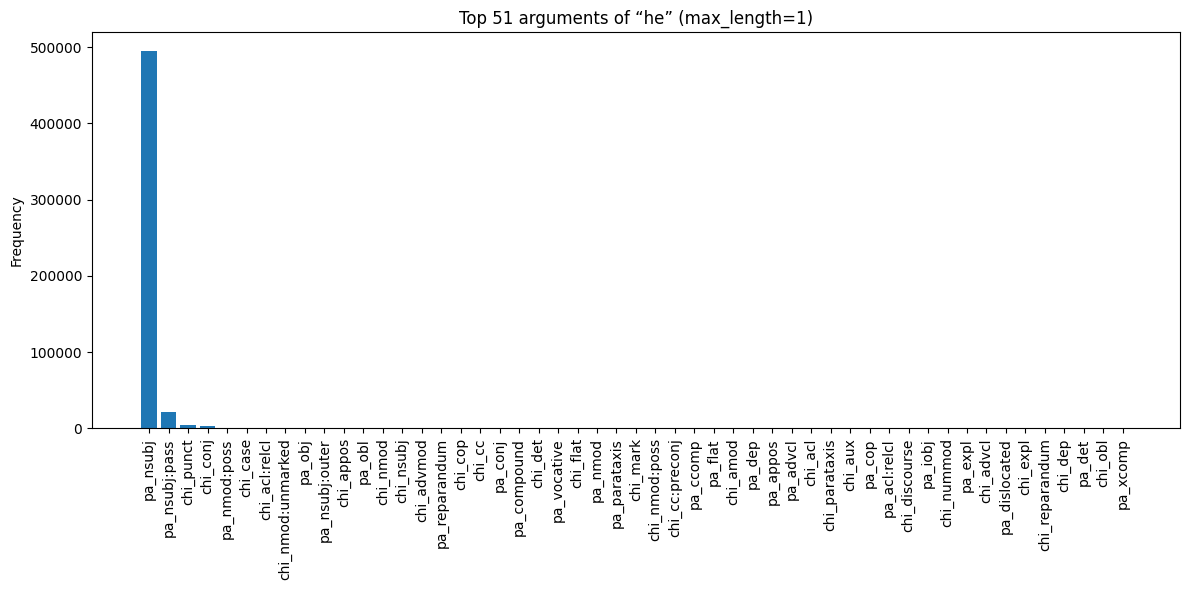

Saved path frequencies to: /home/volt/bach/SynFlow/output/he/he_P_arguments.json


In [13]:
import importlib
import SynFlow.arg_explorer
importlib.reload(SynFlow.arg_explorer)
from SynFlow.arg_explorer import arg_explorer

dist = arg_explorer(
    corpus_folder=corpus_folder,
    target_lemma=target_lemma,
    target_pos=target_pos,
    max_length=1,
    top_n=51,
    pattern=pattern,
    output_folder=output_folder
)

## Unique Argument Combination Explorer

In [ ]:
# 1 unique full-pattern string for 1 token

import importlib
import SynFlow.arg_comb_explorer
importlib.reload(SynFlow.arg_comb_explorer)
from SynFlow.arg_comb_explorer import arg_comb_explorer

ctr = arg_comb_explorer(
    corpus_folder=corpus_folder,
    target_lemma=target_lemma,
    target_pos=target_pos,
    max_length=1,
    top_n=30,
    output_folder=output_folder,
    pattern=pattern
)

## Rel Explorer

In [14]:
import importlib
import SynFlow.rel_explorer
importlib.reload(SynFlow.rel_explorer)
from SynFlow.rel_explorer import rel_explorer

triples = rel_explorer(
    corpus_folder=corpus_folder,
    pattern=pattern,            # or leave None to use default
    target_lemma=target_lemma,
    target_pos=target_pos,
    rel="pa_nsubj",
)

# inspect a few
# for sent, ctx_list, path in triples[:10]:
#     print(f"{path:>15}  {' > '.join(ctx_list):20} | {sent}")

for fname, sent, ctx_list, path in triples[:10]:
    # ctx_list là một list các "lemma/pos", nối bằng ' > ' để in cho dễ nhìn
    ctx_chain = " > ".join(ctx_list)
    print(f"{fname:20} | {path:15} | {ctx_chain:20} | {sent}")

fic_1911_14612_cleaned_part4.txt | pa_nsubj        | powerful/J           | His hair is already prematurely gray , and while he is powerful to the eye , a close observer might detect signs of physical weakness .
fic_1911_14612_cleaned_part4.txt | pa_nsubj        | live/V               | He has evidently lived an intent life aimed at a great desire and shadowed by deep sorrow .
fic_1922_1553_cleaned_part4.txt | pa_nsubj        | know/V               | He would know it was only " make-believe " if she got down on her knees and prayed for forgiveness .
fic_1916_14338_cleaned_part5.txt | pa_nsubj        | proceed/V            | Then he proceeds .
fic_1914_3214_cleaned_part7.txt | pa_nsubj        | move/V               | As he moved toward the " L " station at the corner , Sadie and his mother waved to him ; in the street , boys too small to be scouts hailed him enviously ; even the policeman glancing over the newspapers on the nodded approval . "
fic_1914_3214_cleaned_part7.txt | pa_nsubj 

## Full Rel Explorer

In [ ]:

import importlib
import SynFlow.full_rel_explorer
importlib.reload(SynFlow.full_rel_explorer)
from SynFlow.full_rel_explorer import full_rel_explorer

triples = full_rel_explorer(
    corpus_folder=corpus_folder,
    pattern=pattern,            # or leave None to use default
    target_lemma=target_lemma,
    target_pos=target_pos,
    rel="chi_advmod & chi_aux & chi_nsubj & chi_obj & chi_punct",
    # rel="chi_aux & chi_nsubj & chi_obj & chi_punct",
    # rel="chi_discourse > chi_punct & chi_punct",
    mode = 'open', # 'open', 'close', 'closeh'
    max_check_depth=2
)

print(len(triples))

# inspect a few
for fname, sent, found_paths_details_list in triples[:10]:
    # found_paths_details_list is a list of (ctx_nodes, path_str) tuples
    for ctx_nodes, path_str in found_paths_details_list:
        # ctx_nodes is a list of "lemma/pos", join using ' > ' to print
        ctx_chain = " > ".join(ctx_nodes)
        print(f"{fname:20} | {path_str:15} | {ctx_chain:20} | {sent}")

## Trimming

In [14]:
import pandas as pd
df = pd.read_csv('/home/volt/bach/SynFlow/output/miss/miss_arg_comb_2_hops.csv', sep='&')
df

,Frequency,Target,Slot1,Slot2,Slot3,Slot4,Slot5,Slot6,Slot7,Slot8,...,Slot26,Slot27,Slot28,Slot29,Slot30,Slot31,Slot32,Slot33,Slot34,Slot35
0,25,miss,> chi_advmod,> chi_aux,> chi_nsubj,> chi_obj,> chi_punct,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16,miss,> chi_aux,> chi_nsubj,> chi_obj,> chi_punct,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,miss,> chi_aux,> chi_nsubj,> pa_acl:relcl > pa_obj,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,miss,> chi_advmod,> chi_nsubj,> chi_obj,> chi_punct,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,miss,> chi_discourse > chi_punct,> chi_punct,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,1,miss,> chi_advcl > chi_advmod,> chi_advcl > chi_mark,> chi_advcl > chi_obj,> chi_advcl > chi_obl,> chi_advcl > chi_punct,> chi_advmod > chi_punct,> chi_nsubj > chi_det,> chi_obj > chi_amod,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3338,1,miss,> chi_advmod,> chi_aux,> chi_cc,> chi_nsubj,> chi_obj,> chi_obl > chi_case,> chi_obl > chi_det,> pa_conj > chi_advmod,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3339,1,miss,> chi_advmod > chi_advmod,> chi_cc,> chi_nsubj,> chi_obj,> chi_punct,> pa_conj > chi_advmod,> pa_conj > chi_aux,> pa_conj > chi_nsubj,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3340,1,miss,> chi_conj > chi_advmod,> chi_conj > chi_aux,> chi_conj > chi_cc,> chi_conj > chi_iobj,> chi_conj > chi_nsubj,> chi_conj > chi_punct,> chi_conj > chi_xcomp,> chi_obj,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
import importlib
import SynFlow.trimming
importlib.reload(SynFlow.trimming)
from SynFlow.trimming import trim_and_merge
df_file = '/home/volt/bach/SynFlow/output/miss/miss_arg_comb_2_hops.csv'
trimmed_rels = ['chi_punct', 'chi_det', 'pa_parataxis','chi_discourse']
trim_and_merge(df_file=df_file, trimmed_rels=trimmed_rels)

/home/volt/bach/SynFlow/SynFlow/trimming.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[slot_cols] = df[slot_cols].replace("", np.nan)


Saved merged file to /home/volt/bach/SynFlow/output/miss/miss_arg_comb_2_hops_trimmed.csv


,Frequency,Target,Slot_1,Slot_2,Slot_3,Slot_4,Slot_5,Slot_6,Slot_7,Slot_8,...,Slot_25,Slot_26,Slot_27,Slot_28,Slot_29,Slot_30,Slot_31,Slot_32,Slot_33,Slot_34
651,48,miss,> chi_advmod,> chi_aux,> chi_nsubj,> chi_obj,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1644,28,miss,> chi_aux,> chi_nsubj,> chi_obj,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2789,22,miss,> chi_obj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2602,20,miss,> chi_nsubj,> chi_obj,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051,18,miss,> chi_advmod,> chi_nsubj,> chi_obj,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,1,miss,> chi_advmod,> chi_nsubj,> chi_obj,> chi_obj > chi_acl:relcl,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1055,1,miss,> chi_advmod,> chi_nsubj,> chi_obj,> chi_obj > chi_acl:relcl,> chi_obj > chi_amod,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057,1,miss,> chi_advmod,> chi_nsubj,> chi_obj,> chi_obj > chi_amod,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1058,1,miss,> chi_advmod,> chi_nsubj,> chi_obj,> chi_obj > chi_amod,> chi_obj > chi_nmod,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Specialisations Grouping

In [16]:
import importlib
import SynFlow.trimming
importlib.reload(SynFlow.trimming)
from SynFlow.trimming import spe_group

df_path = '/home/volt/bach/SynFlow/output/miss/miss_arg_comb_2_hops_trimmed.csv'
tree = spe_group(df_path, output_folder=output_folder, target_lemma=target_lemma)

Saved to /home/volt/bach/SynFlow/output/miss/miss_arg_comb_grouped.json


# Get Slot df

In [ ]:
import importlib
import SynFlow.get_embeddings
importlib.reload(SynFlow.get_embeddings)
from SynFlow.get_embeddings import build_slot_df

df_slots = build_slot_df(
    corpus_folder=corpus_folder,
    template='[pa_nsubj]',
    target_lemma=target_lemma,
    target_pos=target_pos,
    pattern=pattern,
    freq_path='/home/volt/bach/SynFlow/COHA_10_20_lemma_deprel_freq.txt',
    freq_min=1,
    freq_max=100_000_000,
    filtered_pos=[],
    filler_format='lemma/deprel',
    out_template_csv=f'{output_folder}/{target_lemma}_samples_all_slots.csv'
)

Wrote slot‐fillers to /home/volt/bach/SynFlow/output/he/he_samples_all_slots.csv (494765 rows), dropped 27482 tokens.


In [ ]:
# Sampling from the general slots DataFrame
import importlib
import SynFlow.get_embeddings
importlib.reload(SynFlow.get_embeddings)
from SynFlow.get_embeddings import sample_slot_df
n = 500
df_sample = sample_slot_df(
    input_csv=f"{output_folder}/{target_lemma}_samples_all_slots.csv",
    output_csv=f"{visualisation_folder}/{target_lemma}_samples_{n}_slots.csv",
    n=n,
    seed=42,
    mode= 'NA'
)

In [ ]:
# template='[chi_nsubj][chi_obj][chi_obl > chi_case]'
# slots     = template.strip("[]").split("][")
# print(slots)

# Get Embeddings

In [ ]:
import pandas as pd
import importlib
import SynFlow.get_embeddings
importlib.reload(SynFlow.get_embeddings)
from SynFlow.get_embeddings import build_embeddings
n = 1000
df_emb = build_embeddings(
    df_templates=pd.read_csv(f'{visualisation_folder}/{target_lemma}_samples_{n}_slots.csv', index_col=0), # df_slots,
    type_embedding_path='/home/volt/bach/SynFlow/type_embedding/coha_10_20_w2v.csv',
    dims=300,
    slot_mode='mult',
    tok_mode='mult',
    out_embedding=f'{visualisation_folder}/{target_lemma}_samples_{n}'
)

In [ ]:
import pandas as pd
df = pd.read_csv('/home/volt/bach/SynFlow/type_embedding/coha_10_20_w2v.csv', index_col=0)
df.head()

# Calculate Cosine Similarity

In [ ]:
import pandas as pd
import importlib
import SynFlow.compute_dist
importlib.reload(SynFlow.compute_dist)
from SynFlow.compute_dist import compute_cosine_distmtx

# Example usage:
df_emb = pd.read_csv(f"{visualisation_folder}/{target_lemma}_samples_{n}_embeddings.csv", index_col=0)
dist_df = compute_cosine_distmtx(df_emb)
dist_df.to_csv(f"{visualisation_folder}/{target_lemma}_samples_{n}_distance_matrix.csv")

In [ ]:
# Play around with the cosine similarity
import numpy as np

def cosine_similarity_np(vec1, vec2):
    """
    Calculates the cosine similarity between two vectors using NumPy.

    Args:
        vec1 (numpy.ndarray or list): The first vector.
        vec2 (numpy.ndarray or list): The second vector.

    Returns:
        float: The cosine similarity between the two vectors.
               Returns 0 if either vector has a magnitude of zero.
    """
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)

    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0  # Or handle as an error, depending on desired behavior
    else:
        return dot_product / (norm_vec1 * norm_vec2)

# Example Usage:
vector_a = [1, 2, 3, 4, 5, 6, 7, 8]
vector_b = [3, 5, 7, 9, 11, 13, 15, 17]

vector_c = [5, 6, 7, 8, 1, 2, 3, 4]
vector_d = [11, 13, 15, 17, 3, 5, 7, 9]

# vector_a = [1, 1, 1, 1, 2, 2, 2, 2]
# vector_b = [1, 1, 1, 1, 2, 2, 2, 2]

similarity = cosine_similarity_np(vector_a, vector_b)
print(f"Cosine Similarity (NumPy): {similarity}")

similarity = cosine_similarity_np(vector_c, vector_d)
print(f"Cosine Similarity (NumPy): {similarity}")

# Get Context

In [ ]:
import importlib
import SynFlow.get_contexts
importlib.reload(SynFlow.get_contexts)
from SynFlow.get_contexts import corpus_handler, get_contexts
import re
pattern = re.compile(
    r'([^\t]+)\t'      # FORM
    r'([^\t]+)\t'      # LEMMA
    r'([^\t])[^\t]*\t' # POS
    r'([^\t]+)\t'      # ID
    r'([^\t]+)\t'      # HEAD
    r'([^\t]+)'        # DEPREL
)

In [ ]:
import pandas as pd

slots_df = pd.read_csv(f"{visualisation_folder}/{target_lemma}_samples_{n}_slots.csv", index_col=0)

# Now attach contexts:
context_df = get_contexts(
    slots_df=slots_df,
    corpus_path="/home/volt/bach/pilot_data/COHA/10_20_parsed_1_SPOS",
    pattern=pattern,
    output_path=f"{visualisation_folder}/{target_lemma}_samples_{n}_contexts.csv"
)

# Get Clustering

In [ ]:
import pandas as pd
import hdbscan

def hdbscan_clustering(dist_df: pd.DataFrame,
                          min_cluster_size: int = 5,
                          min_samples: int = None,
                          cluster_selection_epsilon: float = 0.0,
                          cluster_selection_method: str = 'eom',
                         ) -> pd.DataFrame:
    """
    Given a precomputed distance matrix `dist_df` (square DataFrame indexed and
    columned by token IDs), run HDBSCAN (metric='precomputed') and return a new
    DataFrame with two columns:
      • 'token'   : the token ID (index of dist_df)
      • 'cluster' : the HDBSCAN cluster label (-1 for noise)
    
    Parameters
    ----------
    dist_df : pd.DataFrame
        Square distance matrix (n × n), index and columns are identical token IDs.
    min_cluster_size : int, default=5
        The minimum size of clusters; see HDBSCAN docs.
    min_samples : int or None, default=None
        Controls how conservative the clustering is; if None, it defaults to
        min_cluster_size.
    cluster_selection_epsilon : float, default=0.0
        A distance threshold: clusters below this distance can be split off.
    cluster_selection_method : {'eom','leaf'}, default='eom'
        How to select clusters from the condensed tree.

    Returns
    -------
    pd.DataFrame with columns ['id','cluster'], index 0..n-1
    """
    # Extract the numpy distance matrix
    D = dist_df.values
    # Initialize HDBSCAN with precomputed distances
    clusterer = hdbscan.HDBSCAN(
        metric='precomputed',
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        cluster_selection_method=cluster_selection_method
    )
    # Fit on the distance matrix
    clusterer.fit(D)
    labels = clusterer.labels_  # array of length n, -1 means noise

    # Prefix each label with 'c'
    clusters_prefixed = [f"c{lab}" for lab in labels]

    result = pd.DataFrame({
        'id': dist_df.index,
        'clusters': clusters_prefixed
    }).reset_index(drop=True)

    return result


In [ ]:
import pandas as pd

# Suppose you already computed dist_df (square DataFrame with token IDs as index & columns)
dist_df = pd.read_csv(fr'{visualisation_folder}/{target_lemma}_samples_{n}_distance_matrix.csv', index_col=0)

# Cluster with HDBSCAN
cluster_df = hdbscan_clustering(
    dist_df,
    min_cluster_size=10,
    min_samples=10
)

# Save to CSV if desired
cluster_df.to_csv(fr'{visualisation_folder}/{target_lemma}_samples_{n}_clusters.csv', index=False)

# Merge to context
context_df = pd.read_csv(fr'{visualisation_folder}/{target_lemma}_samples_{n}_contexts.csv', index_col=0)
cluster_context_df = context_df.merge(cluster_df, left_index=True, right_on='id')

# Save to CSV if desired
cluster_context_df.to_csv(fr'{visualisation_folder}/{target_lemma}_samples_{n}_clusters_contexts.csv', index=False)


# Get Coordinates with tsne, umap, mds

In [ ]:
import pandas as pd
import importlib
import SynFlow.get_coordinates
importlib.reload(SynFlow.get_coordinates)
from SynFlow.get_coordinates import get_token_coordinates

In [ ]:
# Example usage:
dist_df = pd.read_csv(f'{visualisation_folder}/{target_lemma}_samples_{n}_distance_matrix.csv', index_col=0)
coord_tsne = get_token_coordinates(lemma=f'{target_lemma}_samples', dist_df=dist_df, method='tsne', perplexity=30, output_path=visualisation_folder, n = n)
# coord_mds  = get_token_coordinates(lemma=f'{target_lemma}_samples', dist_df=dist_df, method='mds', max_iter=300, output_path=visualisation_folder, n = n)
coord_umap = get_token_coordinates(lemma=f'{target_lemma}_samples', dist_df=dist_df, method='umap', n_neighbors=30, min_dist=0.1, output_path=visualisation_folder, n = n)

# Visualise with plotly

In [ ]:
import importlib
import SynFlow.visualisation
importlib.reload(SynFlow.visualisation)
from SynFlow.visualisation import get_token_ids

In [ ]:
input_coords = fr'{visualisation_folder}/{target_lemma}_samples_{n}_tsne.csv'
input_ctxs = fr'{visualisation_folder}/{target_lemma}_samples_{n}_clusters_contexts.csv'

get_token_ids(input_coords, input_ctxs)